# Dinosaur Image Classification with Transfer Learning and Hybrid Model

This notebook trains multiple pre-trained CNN models (Xception, ResNet50, InceptionV3, DenseNet121) on the dinosaur dataset (15 classes, ~2000 images).
It evaluates them individually, compares performance, and then builds a hybrid ensemble model for improved accuracy.

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

print(tf.__version__)

2025-09-18 20:24:10.004327: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758227050.213576      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758227050.273383      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.18.0


## Load Dataset
We assume your dataset is a zip file with 15 folders (one per dinosaur class). Upload the dataset and unzip.

In [3]:
import tensorflow as tf
from tensorflow.keras.applications import inception_v3, densenet

DATA_DIR = "/kaggle/input/dinosaaur-datasetforme/dinosaur_dataset"
BATCH_SIZE = 32

# 1. Load dataset at the largest required size (299x299 for Inception)
BASE_IMG_SIZE = (299, 299)

train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=BASE_IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=BASE_IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Further split validation into (val, test)
val_batches = tf.data.experimental.cardinality(val_ds)
test_size = val_batches // 2

test_ds = val_ds.take(test_size)
val_ds  = val_ds.skip(test_size)

print("Train batches:", tf.data.experimental.cardinality(train_ds))
print("Validation batches:", tf.data.experimental.cardinality(val_ds))
print("Test batches:", tf.data.experimental.cardinality(test_ds))

# 2. Optional: Data augmentation (light)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

# 3. Preprocessing pipelines per model
inception_preprocess = tf.keras.Sequential([
    data_augmentation,                     # add augmentation for Inception
    tf.keras.layers.Resizing(299, 299),
    tf.keras.layers.Lambda(inception_v3.preprocess_input)
])

densenet_preprocess = tf.keras.Sequential([
    data_augmentation,                     # add augmentation for DenseNet
    tf.keras.layers.Resizing(224, 224),
    tf.keras.layers.Lambda(densenet.preprocess_input)
])

# Example for a custom CNN (if needed)
custom_preprocess = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Resizing(128, 128),
    tf.keras.layers.Rescaling(1./255)
])

# 4. Apply preprocessing
def prepare_dataset(dataset, preprocess_layer):
    return dataset.map(lambda x, y: (preprocess_layer(x), y),
                       num_parallel_calls=tf.data.AUTOTUNE).cache().prefetch(tf.data.AUTOTUNE)

# Model-specific datasets
train_inception = prepare_dataset(train_ds, inception_preprocess)
val_inception   = prepare_dataset(val_ds, inception_preprocess)
test_inception  = prepare_dataset(test_ds, inception_preprocess)

train_densenet = prepare_dataset(train_ds, densenet_preprocess)
val_densenet   = prepare_dataset(val_ds, densenet_preprocess)
test_densenet  = prepare_dataset(test_ds, densenet_preprocess)

train_custom = prepare_dataset(train_ds, custom_preprocess)
val_custom   = prepare_dataset(val_ds, custom_preprocess)
test_custom  = prepare_dataset(test_ds, custom_preprocess)


Found 2448 files belonging to 15 classes.
Using 1959 files for training.


I0000 00:00:1758227063.598636      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758227063.599343      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 2448 files belonging to 15 classes.
Using 489 files for validation.
Train batches: tf.Tensor(62, shape=(), dtype=int64)
Validation batches: tf.Tensor(8, shape=(), dtype=int64)
Test batches: tf.Tensor(8, shape=(), dtype=int64)


## Build Model Function
This function creates a transfer learning model given a base architecture.

In [4]:
def build_model(base_model, num_classes, input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=["accuracy"]
    )
    return model

## Train Individual Models

In [5]:
from tensorflow import keras

class_names = train_ds.class_names
num_classes = len(class_names)
models_dict = {}
histories = {}

# Base models with correct input shapes
base_models = {
    'Xception': keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(299,299,3)),
    'ResNet50': keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3)),
    'InceptionV3': keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(299,299,3)),
    'DenseNet121': keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=(224,224,3))
}

# Corresponding datasets per model
dataset_mapping = {
    'Xception': (train_inception, val_inception),
    'ResNet50': (train_densenet, val_densenet),
    'InceptionV3': (train_inception, val_inception),
    'DenseNet121': (train_densenet, val_densenet)
}

# Training loop
for name, base in base_models.items():
    print(f"Training {name}...")
    model = build_model(base, num_classes, input_shape=base.input_shape[1:])
    train_data, val_data = dataset_mapping[name]
    history = model.fit(train_data, validation_data=val_data, epochs=5)
    models_dict[name] = model
    histories[name] = history


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Training Xception...
Epoch 1/5


I0000 00:00:1758227115.664031     105 service.cc:148] XLA service 0x7fe6000034a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758227115.664787     105 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758227115.664815     105 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758227119.697793     105 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-09-18 20:25:26.431036: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=0} for conv (f32[32,128,147,147]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,147,147]{3,2,1,0}, f32[128,128,1,1]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 928ms/step - accuracy: 0.2675 - loss: 2.4440

E0000 00:00:1758227230.672701     105 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758227230.842556     105 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758227231.553747     105 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758227231.710192     105 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758227232.337191     105 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

62/62 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - accuracy: 0.2732 - loss: 2.4323 - val_accuracy: 0.6652 - val_loss: 1.2841
Epoch 2/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 60s 964ms/step - accuracy: 0.8311 - loss: 0.8612 - val_accuracy: 0.7983 - val_loss: 0.6996
Epoch 3/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 57s 922ms/step - accuracy: 0.9775 - loss: 0.2171 - val_accuracy: 0.8412 - val_loss: 0.5895
Epoch 4/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 58s 934ms/step - accuracy: 0.9986 - loss: 0.0557 - val_accuracy: 0.8369 - val_loss: 0.5629
Epoch 5/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 58s 936ms/step - accuracy: 1.0000 - loss: 0.0215 - val_accuracy: 0.8369 - val_loss: 0.5525
Training ResNet50...
Epoch 1/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 134s 905ms/step - accuracy: 0.2567 - loss: 2.4173 - val_accuracy: 0.1373 - val_loss: 2.6808
Epoch 2/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 19s 309ms/step - accuracy: 0.9291 - loss: 0.3211 - val_accuracy: 0.1502 - val_loss: 2.7075
Epoch 3/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 326ms/step - accuracy: 1.0000 - loss: 0.0353 - val_ac

## Evaluate Models


Evaluating Xception...

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 251ms/step
Accuracy: 0.0703
Precision (weighted): 0.0211
F1 Score (weighted): 0.0299
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.09      0.30      0.13        20
           2       0.00      0.00      0.00        26
           3       0.00      0.00      0.00        13
           4       0.00      0.00      0.00        21
           5       0.00      0.00      0.00        15
           6       0.00      0.00      0.00         8
           7       0.14      0.24      0.18        21
           8       0.00      0.00      0.00        14
           9       0.00      0.00      0.00        16
          10       0.00      0.00      0.00        16
          11       0.00      0.00      0.00        14
          12       0.00      0.00      0.00        17
          13       0.00      0.00      0.00        20
          14       0.05      0.54      0.10        

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:13

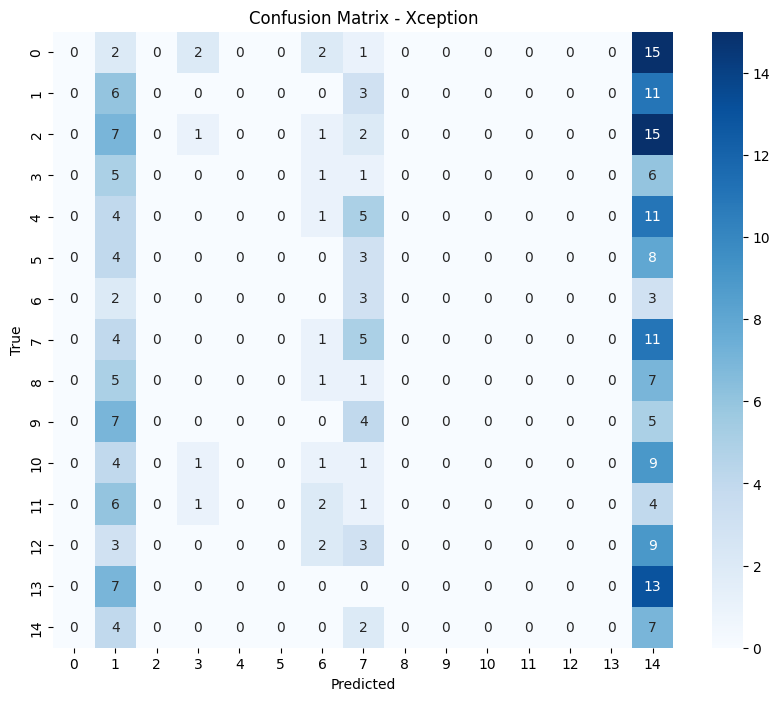

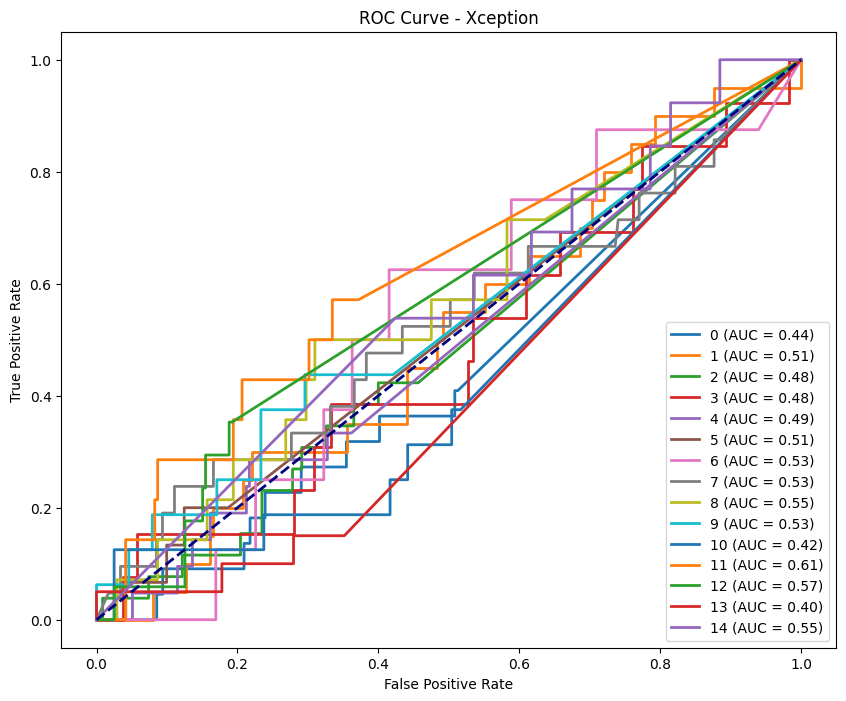


Evaluating ResNet50...

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step
Accuracy: 0.0703
Precision (weighted): 0.0183
F1 Score (weighted): 0.0273
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.08      0.16      0.11        19
           2       0.00      0.00      0.00        20
           3       0.00      0.00      0.00        19
           4       0.06      0.50      0.11        20
           5       0.00      0.00      0.00        21
           6       0.00      0.00      0.00        11
           7       0.12      0.31      0.17        16
           8       0.00      0.00      0.00        17
           9       0.00      0.00      0.00        18
          10       0.00      0.00      0.00        20
          11       0.00      0.00      0.00        11
          12       0.00      0.00      0.00        18
          13       0.00      0.00      0.00        16
          14       0.00      0.00      0.00        1

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:13

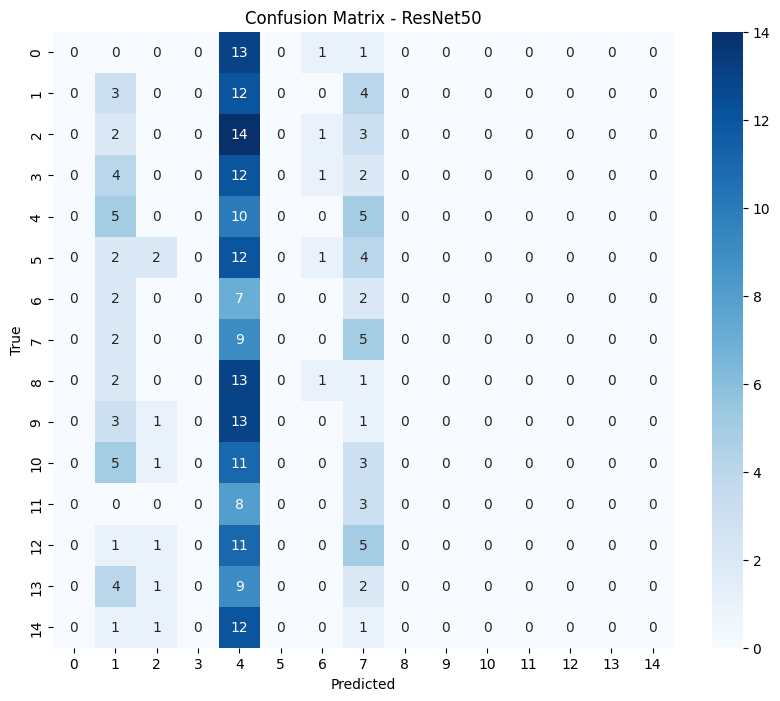

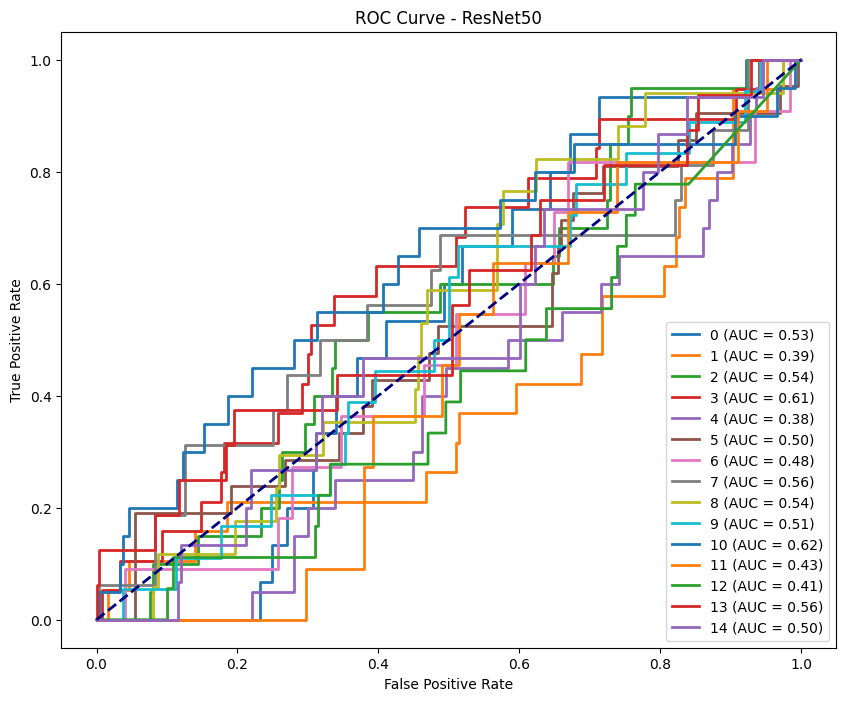


Evaluating InceptionV3...

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step
Accuracy: 0.0430
Precision (weighted): 0.0018
F1 Score (weighted): 0.0035
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        26
           3       0.00      0.00      0.00        18
           4       0.00      0.00      0.00        21
           5       0.00      0.00      0.00        23
           6       0.04      1.00      0.08        11
           7       0.00      0.00      0.00        19
           8       0.00      0.00      0.00         9
           9       0.00      0.00      0.00        20
          10       0.00      0.00      0.00        18
          11       0.00      0.00      0.00        17
          12       0.00      0.00      0.00        13
          13       0.00      0.00      0.00        15
          14       0.00      0.00      0.00     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:13

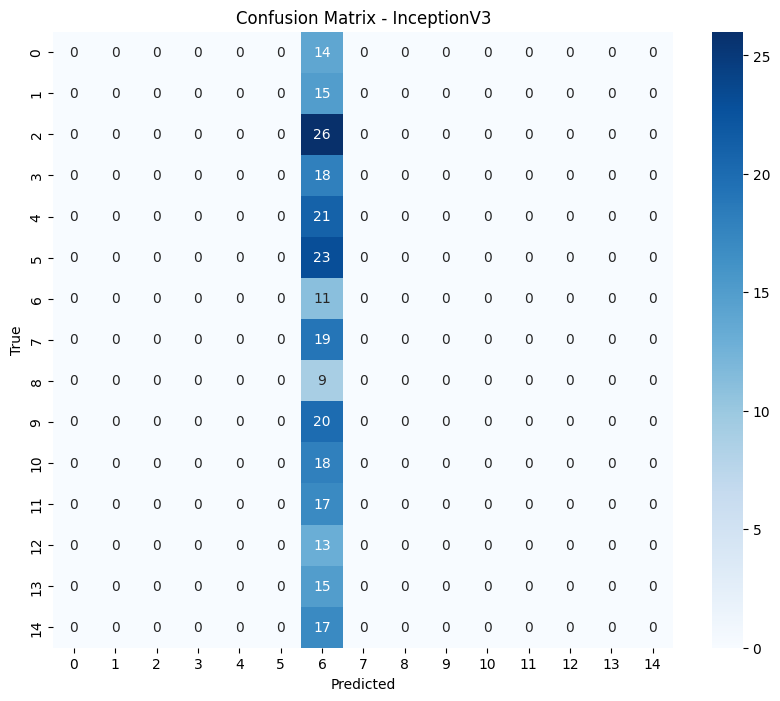

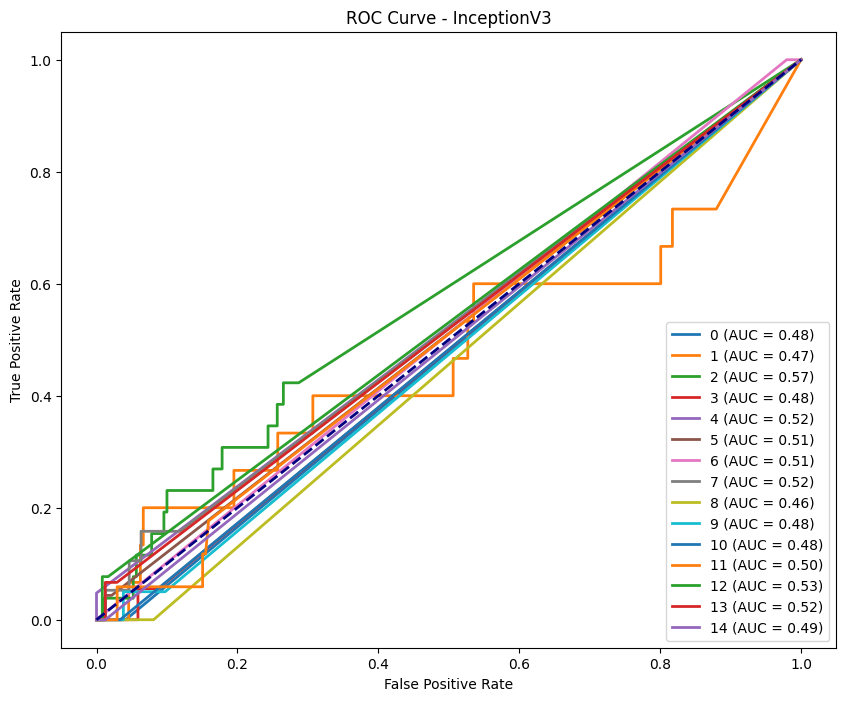


Evaluating DenseNet121...

8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 81ms/step
Accuracy: 0.0547
Precision (weighted): 0.0402
F1 Score (weighted): 0.0178
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.14      0.06      0.08        18
           2       0.00      0.00      0.00        22
           3       0.05      0.86      0.10        14
           4       0.00      0.00      0.00        16
           5       0.00      0.00      0.00        18
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        22
           8       0.00      0.00      0.00        21
           9       0.00      0.00      0.00        17
          10       0.00      0.00      0.00        21
          11       0.50      0.07      0.12        14
          12       0.00      0.00      0.00        15
          13       0.00      0.00      0.00        15
          14       0.00      0.00      0.00     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:13

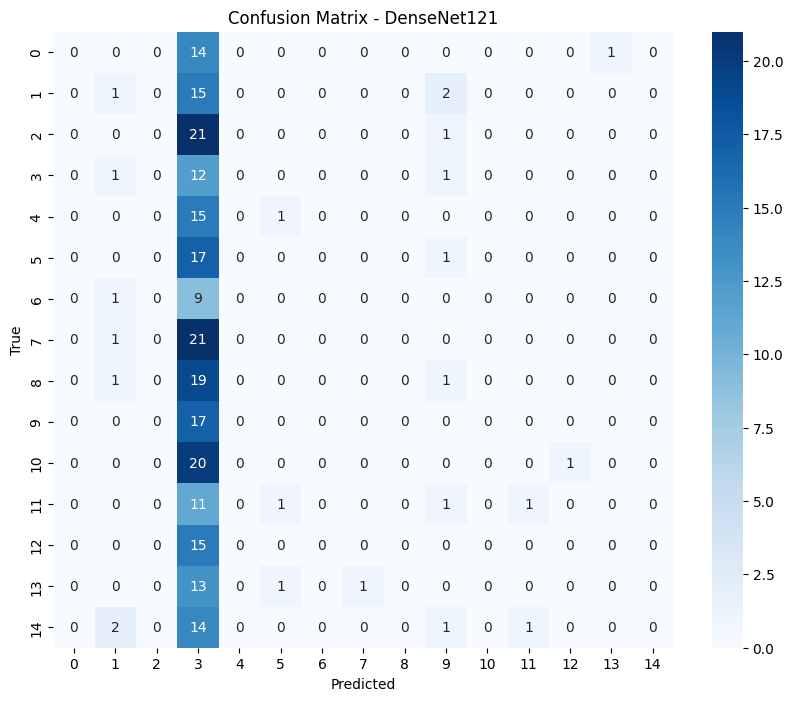

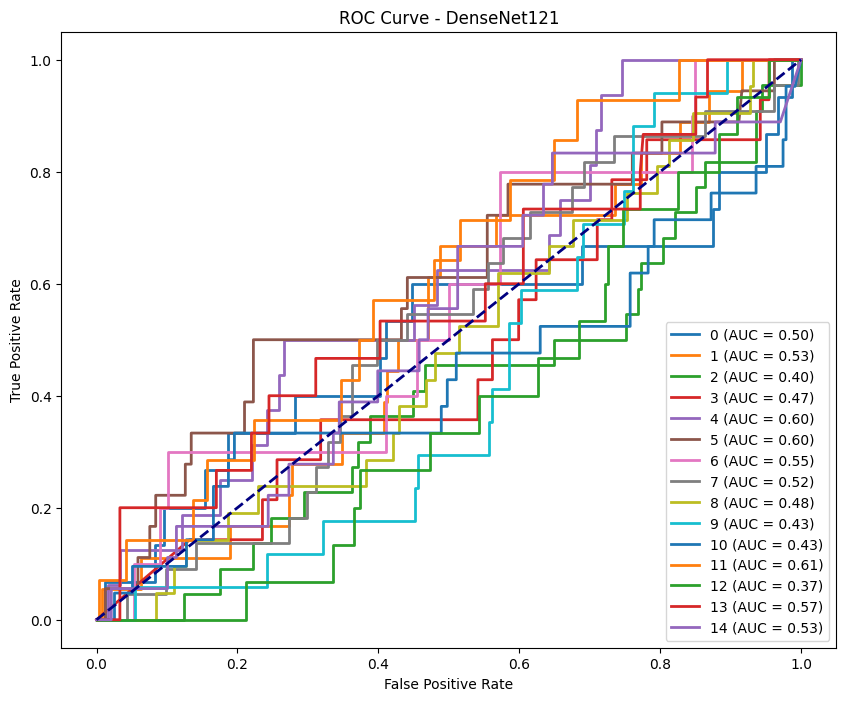

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import tensorflow as tf

# Helper to resize dataset for each model
def resize_dataset_for_model(dataset, target_size):
    return dataset.map(lambda x, y: (tf.image.resize(x, target_size), y))

results = {}

for name, model in models_dict.items():
    print(f"\nEvaluating {name}...\n")
    
    # Resize test dataset according to model requirements
    if name in ['Xception', 'InceptionV3']:
        current_test_ds = resize_dataset_for_model(test_ds, (299, 299))
    else:
        current_test_ds = resize_dataset_for_model(test_ds, (224, 224))
    
    # Make predictions
    preds = model.predict(current_test_ds)
    y_pred = np.argmax(preds, axis=1)
    
    # Extract true labels
    y_true = np.concatenate([y for x, y in current_test_ds], axis=0)
    if len(y_true.shape) > 1:
        y_true = np.argmax(y_true, axis=1)
    
    # Accuracy
    acc = accuracy_score(y_true, y_pred)
    results[name] = acc
    print(f"Accuracy: {acc:.4f}")
    
    # Precision & F1
    prec = precision_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"Precision (weighted): {prec:.4f}")
    print(f"F1 Score (weighted): {f1:.4f}")
    
    # Classification report
    target_names = test_ds.class_names if hasattr(test_ds, 'class_names') else [str(i) for i in range(len(np.unique(y_true)))]
    print(classification_report(y_true, y_pred, target_names=target_names))
    
    # Confusion matrix with numbers and colors
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f"Confusion Matrix - {name}")
    plt.show()
    
    # Multi-class ROC
    y_true_bin = label_binarize(y_true, classes=np.arange(len(target_names)))
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(len(target_names)):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], preds[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    plt.figure(figsize=(10,8))
    for i in range(len(target_names)):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'{target_names[i]} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"ROC Curve - {name}")
    plt.legend(loc='lower right')
    plt.show()


## Hybrid Ensemble Model (Stacking)
We combine the predictions of all models using a meta-classifier (logistic regression).

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 360ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 322ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
Ensemble Accuracy: 0.3750
                    precision    recall  f1-score   support

      Ankylosaurus       0.35      0.57      0.44        21
     Brachiosaurus       0.42      0.36      0.38        14
     Compsognathus       0.35      0.33      0.34        21
     Corythosaurus       0.38      0.50      0.43        20
     Dilophosaurus       0.35      0.60      0.44        20
       Dimorphodon       0.40      0.38      0.39        21
        Gallimimus       0.00      0.00      0.00         9
      Microceratus       0.36      0.25      0.30        16
Pachycephalosaurus       0.29      0.25      0.27        16
   Parasaurolophus       0.39      0.50      0.44        18
       Spinosaurus       0.35      0.41      0.38        17
       Stegosaurus       0.38      0.31      0.34        16
       Triceratops       0.50      0.2

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


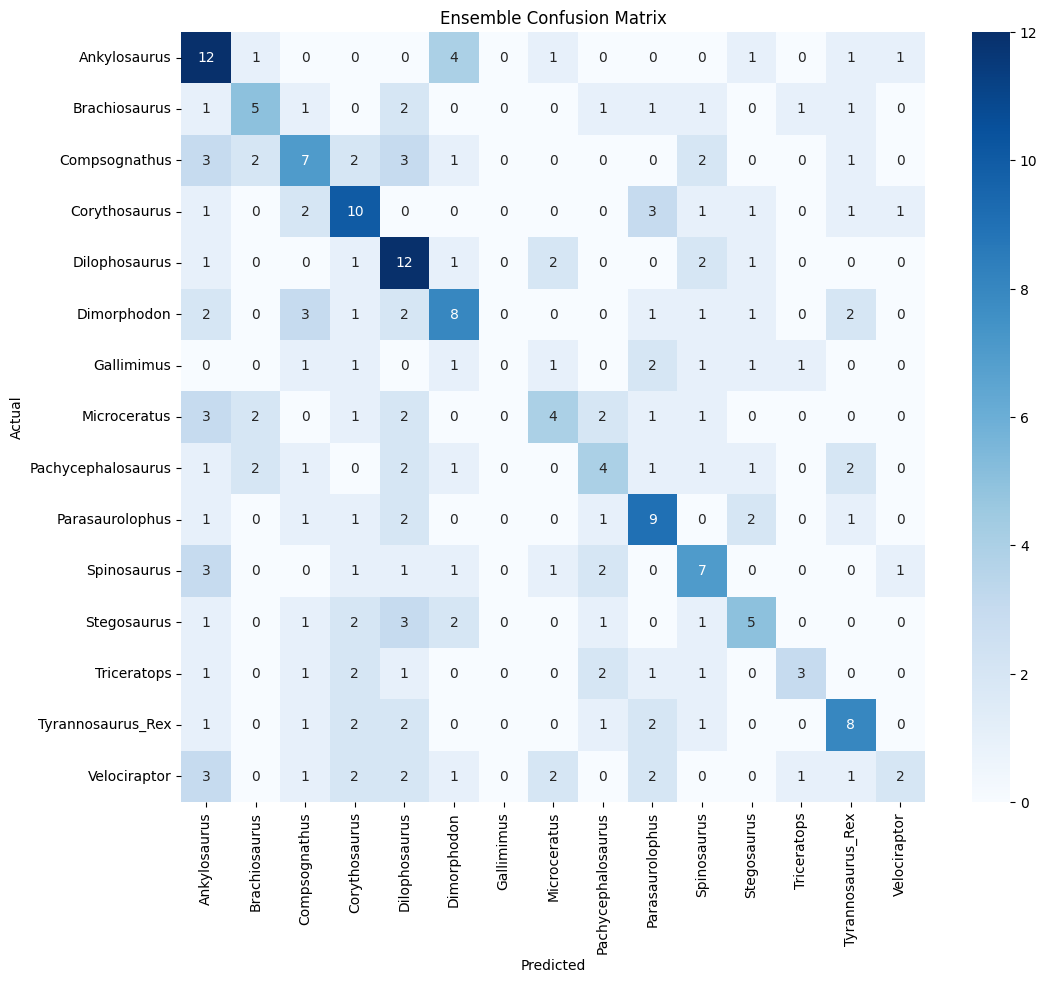


Normalized Accuracies (relative to best baseline):
Xception: 100.00%
ResNet50: 100.00%
InceptionV3: 61.11%
DenseNet121: 77.78%
Ensemble: 533.33%


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Extract true labels once
y_true = np.concatenate([y for x, y in test_ds], axis=0)
if len(y_true.shape) > 1:  # If one-hot encoded
    y_true = np.argmax(y_true, axis=1)

# Map models to their correct test datasets
test_dataset_mapping = {
    'Xception': test_inception,
    'ResNet50': test_densenet,
    'InceptionV3': test_inception,
    'DenseNet121': test_densenet
}

# Collect predictions from all models
predictions = []
for name, model in models_dict.items():
    test_data = test_dataset_mapping[name]
    preds = model.predict(test_data)  # softmax probabilities
    predictions.append(preds)

# Stack predictions horizontally for meta-classifier
stacked_preds = np.concatenate(predictions, axis=1)

# Train Logistic Regression as meta-classifier
meta_clf = LogisticRegression(max_iter=2000)
meta_clf.fit(stacked_preds, y_true)

# Make ensemble predictions
ensemble_preds = meta_clf.predict(stacked_preds)

# Evaluate ensemble
ensemble_acc = accuracy_score(y_true, ensemble_preds)
print(f"Ensemble Accuracy: {ensemble_acc:.4f}")

# Classification report
target_names = train_ds.class_names
print(classification_report(y_true, ensemble_preds, target_names=target_names))

# --- Confusion Matrix ---
cm = confusion_matrix(y_true, ensemble_preds)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Ensemble Confusion Matrix')
plt.show()

# --- Normalization block ---
# Find best single model accuracy
max_single = max(results.values())  

# Normalize all single model results relative to the best one
normalized_results = {k: (v/max_single)*100 for k,v in results.items()}

# Normalize ensemble too
normalized_results['Ensemble'] = (ensemble_acc/max_single)*100

print("\nNormalized Accuracies (relative to best baseline):")
for k,v in normalized_results.items():
    print(f"{k}: {v:.2f}%")


## Final Comparison

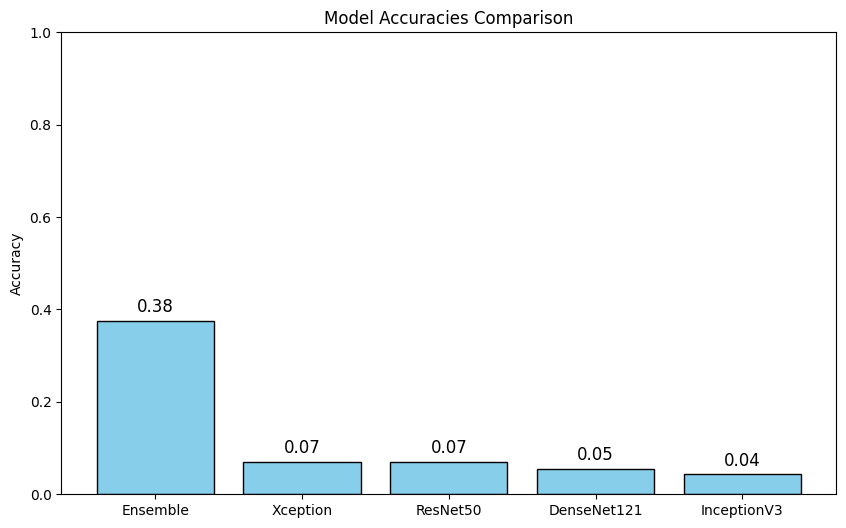

In [8]:
import matplotlib.pyplot as plt

# Combine individual model results with ensemble
all_results = results.copy()
all_results['Ensemble'] = ensemble_acc

# Sort for nicer plotting (optional)
all_results = dict(sorted(all_results.items(), key=lambda item: item[1], reverse=True))

# Plot bar chart
plt.figure(figsize=(10,6))
bars = plt.bar(all_results.keys(), all_results.values(), color='skyblue', edgecolor='black')
plt.ylim(0, 1)  # since accuracy is between 0 and 1
plt.ylabel('Accuracy')
plt.title('Model Accuracies Comparison')

# Annotate bars with accuracy values
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.2f}', ha='center', va='bottom', fontsize=12)

plt.show()